In [191]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

Here are some possible business questions:

- What factors contribute most heavily to the price? 
    - Make a model to predict the price - one that's interpretable and perhaps one (like a neural network) that's not interpretable but does a better job of price prediction.
    - Which listings are underpriced - meaning that the host could make more money by increasing the price, or travelers can get a good deal by booking them?
    - Perhaps extend beyond predicting only base prices to predicting prices at different times of year.
- What should those listings with poor overall review scores do in order to get better reviews in the future?
- What can we discern about the character of each neighborhood using the descriptions?

In [2]:
listings = pd.read_csv("listings.csv")
calendar = pd.read_csv("calendar.csv")

Definitions for many (though not all) of the fields can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896).

Drop columns that have all `NA` values.

In [3]:
for df in [listings, calendar]:
    df.dropna(axis=1, how='all', inplace=True)

Drop rows in `listings` that have `NA` in the `price` field, and do the same for the `price` and `adjusted_price` fields in `calendar`.

In [4]:
listings.dropna(subset=['price'], inplace=True)
calendar.dropna(subset=['price', 'adjusted_price'], inplace=True)

Observe that a dollar sign preceeds the number in several columns; I will remove this so that the field is treated as numeric.

In [5]:
listings['price'] = listings.apply((lambda x: x['price'].replace('$','').replace(',','')), axis=1)
calendar['price'] = calendar.apply((lambda x: x['price'].replace('$','').replace(',','')), axis=1)
calendar['adjusted_price'] = calendar.apply((lambda x: x['adjusted_price'].replace('$','').replace(',','')), axis=1)

The price should be greater than zero. I'll drop all rows where this is not the case.

In [7]:
listings['price'] = listings['price'].astype(np.float64)
calendar['price'] = calendar['price'].astype(np.float64)
calendar['adjusted_price'] = calendar['adjusted_price'].astype(np.float64)

In [8]:
listings.drop(listings.loc[listings['price'] <= 0].index, inplace=True)

Similarly, some of the fields are expressed as percentages; I will remove the percent signs and change the entries to floats.

In [9]:
listings['host_response_rate'] = listings.apply(lambda x: float(x['host_response_rate'].replace('%','')) if pd.notnull(x['host_response_rate']) else x['host_response_rate'], axis=1)
listings['host_acceptance_rate'] = listings.apply(lambda x: float(x['host_acceptance_rate'].replace('%','')) if pd.notnull(x['host_acceptance_rate']) else x['host_acceptance_rate'], axis=1)

# 1. Price prediction

## Data preparation

Split into `X` and `y`.

In [10]:
X = listings.drop('price', axis=1)
y = listings['price']

I also need to deal with dates appropriately. The relevant columns are `host_since`, `first_review`, and `last_review`. I could scrap these columns altogether, but it might be useful to know the length of time since the date for each row. 

In [11]:
for col in ['host_since', 'first_review', 'last_review']:
    X[col] = pd.to_datetime(X['last_scraped']) - pd.to_datetime(X[col])
    X[col] = X.apply(lambda x: x[col].days, axis=1)

Certain columns in `X` are not useful for prediction (for example, URLs), and should be removed.

In [12]:
to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']
to_drop += ['description', 'neighborhood_overview', 'picture_url', 'host_id']
to_drop += ['host_url', 'host_name', 'host_about', 'host_thumbnail_url']
to_drop += ['host_picture_url', 'license', 'calendar_last_scraped']
X.drop(labels=to_drop, axis=1, inplace=True)

Certain columns (`host_verifications` and `amenities`) are lists of options; I'd like to split these into different columns.

The first step is to change these entries into actual Python lists instead of strings (annoyingly, the two relevant columns are formatted slightly differently, with the roles of single and double quotes being interchanged between them).

In [13]:
X['host_verifications'] = X.apply(lambda x: x['host_verifications'].replace('[','').replace(']','').replace('\'','').split(', '), axis=1)

In [14]:
X['amenities'] = X.apply(lambda x: x['amenities'].replace('\"','').replace('[','').replace(']','').split(', '), axis=1)

What are the possible values in the `host_verifications` lists?

In [15]:
distinct_host_verifications = set()
def find_distinct_hvs(x):
    for hv in x['host_verifications']:
        distinct_host_verifications.add(hv)
X.apply(lambda x: find_distinct_hvs(x), axis=1);

In [16]:
len(distinct_host_verifications)

20

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

In [18]:
m = MultiLabelBinarizer()
hv_df = pd.DataFrame(m.fit_transform(X['host_verifications']), columns=m.classes_, index=X.index)

In [19]:
X = pd.concat([X, hv_df], axis=1)

In [20]:
X.rename(columns={'None' : 'HV_None'}, inplace=True)
# I don't want a column to be called just 'None', so I changed it a bit

Now I can drop the original `host_verifications` column.

In [21]:
X.drop('host_verifications', axis=1, inplace=True)

Now I'd like to do the same for the `amenities` column. What are the possible values in those lists?

In [22]:
distinct_amenities = set()
def find_distinct_amenities(x):
    for a in x['amenities']:
        distinct_amenities.add(a)
X.apply(lambda x: find_distinct_amenities(x), axis=1)
len(distinct_amenities)

976

Ok, that's a lot of amenities. I don't really want to vastly blow up the number of features like this, so I'll just take the 20 most popular amenities.

In [23]:
from collections import defaultdict
from operator import itemgetter

In [24]:
amenity_counts = defaultdict(int) # Initializes to zero for each value
def update_counts(x):
    for a in x['amenities']:
        amenity_counts[a] += 1
X.apply(lambda x: update_counts(x), axis=1);

In [25]:
top_20 = sorted(amenity_counts.items(), key=itemgetter(1), reverse=True)[:20]

In [26]:
top_20[:5]

[('Smoke alarm', 6357),
 ('Essentials', 6185),
 ('Wifi', 6141),
 ('Kitchen', 5930),
 ('Carbon monoxide alarm', 5924)]

In [27]:
top_20_amenities = dict(top_20).keys()

Now I want to get rid of the other amenities in each row.

In [28]:
def find_amenities(x):
    amenities = []
    for a in top_20_amenities:
        if a in x['amenities']:
            amenities.append(a)
    return amenities

In [29]:
X['amenities'] = X.apply(lambda x: find_amenities(x), axis=1)

Now I can create the dummy variables and drop the original `amenities` column.

In [30]:
m = MultiLabelBinarizer()
amenities_df = pd.DataFrame(m.fit_transform(X['amenities']), columns=m.classes_, index=X.index)
X = pd.concat([X, amenities_df], axis=1)
X.drop('amenities', axis=1, inplace=True)

Next, I'll get dummies for the rest of the categorical variables.

In [31]:
X = pd.get_dummies(X, drop_first=True)

In [32]:
X.shape

(6526, 740)

Now I need to deal with `NA` values for the numeric columns. There's no totally ideal way to do this, but to move forward I'll impute using the mean.

In [33]:
fill_mean = lambda col: col.fillna(col.mean())
X = X.apply(fill_mean)

## Modeling and Evaluation

Split into train and test sets.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Instantiate the model, including normalization in the pipeline:

### Linear Model

In [35]:
pipe = make_pipeline(StandardScaler(), LinearRegression())

Fit the model to the training data:

In [36]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [37]:
pipe.score(X_train, y_train)

0.40390584712751165

In [38]:
pipe.score(X_test, y_test)

-2.9633327193593324e+27

In [39]:
pipe.predict(X_train)

array([ -879.52236367,   259.60263633,   382.68484417, ...,
         156.47763633,   747.18484417, -3276.81515583])

In [40]:
y_train

1609     39.0
2302    120.0
3017     60.0
3956    100.0
4051    559.0
        ...  
3772    131.0
5193     50.0
5228    421.0
5392    200.0
860     221.0
Name: price, Length: 4568, dtype: float64

In [41]:
pipe.predict(X_test)

array([  971.18484417,  1824.97763633, -3377.31515583, ...,
         -28.81515583,   904.10263633, -1035.94015583])

Wow, this is really terrible. I think I need to aggressively get rid of features to correct this - I have way too many irrelevant features.

In [223]:
def fit_model(X, y, model, cutoff, random_state=1, cv=False):
    pipe = make_pipeline(StandardScaler(), model)
    X_cutoff = X.iloc[:, np.where((X.sum()/len(X) > cutoff) == True)[0]]
    X_train, X_test, y_train, y_test = train_test_split(
        X_cutoff, y, test_size=0.3, random_state=random_state)
    pipe.fit(X_train, y_train)
    return pipe, X_train, X_test, y_train, y_test

In [203]:
def test_cutoffs(X, y, model, cutoffs):
    results = {}
    for cutoff in cutoffs:
        pipe, X_train, X_test, y_train, y_test = fit_model(X, y, model, cutoff)
        train_score = pipe.score(X_train, y_train)
        test_score = pipe.score(X_test, y_test)
        results[cutoff] = test_score
        print(f"Cutoff = {cutoff: .3g}, train_score = {train_score: .3g}, test_score = {test_score: .3g}, n_features = {X_train.shape[1]}")
    return results

In [193]:
cutoffs = [1000, 1, .99, .9, .7, .5, .3, .2, .1, .05, .01, 0.005, 0]
test_cutoffs(X, y, LinearRegression(), cutoffs);

Cutoff =  1e+03, train_score =  0.00215, test_score =  0.00218, n_features = 4
Cutoff =  1, train_score =  0.0716, test_score =  0.049, n_features = 37
Cutoff =  0.99, train_score =  0.0717, test_score =  0.0499, n_features = 39
Cutoff =  0.9, train_score =  0.206, test_score =  0.157, n_features = 46
Cutoff =  0.7, train_score =  0.293, test_score =  0.211, n_features = 61
Cutoff =  0.5, train_score =  0.297, test_score =  0.218, n_features = 69
Cutoff =  0.3, train_score =  0.3, test_score =  0.219, n_features = 75
Cutoff =  0.2, train_score =  0.3, test_score =  0.219, n_features = 78
Cutoff =  0.1, train_score =  0.316, test_score =  0.237, n_features = 85
Cutoff =  0.05, train_score =  0.329, test_score =  0.246, n_features = 98
Cutoff =  0.01, train_score =  0.362, test_score =  0.257, n_features = 164
Cutoff =  0.005, train_score =  0.377, test_score =  0.254, n_features = 202
Cutoff =  0, train_score =  0.404, test_score = -2.98e+26, n_features = 739


In [102]:
pipe, X_train, X_test, y_train, y_test = fit_model(X, y, LinearRegression(), 0.01)
score = pipe.score(X_test, y_test)
y_pred_L = pipe.predict(X_test)
print(score)

0.2573781071548782


Horrific. And there's another problem: many of the predicted prices are negative!

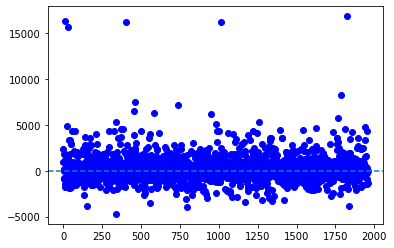

In [106]:
plt.plot(y_pred_L, 'bo')
plt.axhline(y=0, linestyle='--')
plt.show()

### Dealing with outliers

It's worth doing some outlier detection and removal at this point. If a listing has an absurdly high price that isn't reflective of what people will actually pay, or just isn't that relevant for a typical person who wants to list their place, that isn't good for the usefulness of our model.

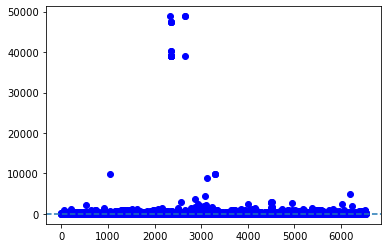

In [232]:
plt.plot(listings['price'], 'bo')
plt.axhline(y=0, linestyle='--')
plt.show()

Yeah, some of these prices look like they might be absurd.

In [236]:
listings['price'].sort_values(ascending=False).head(30)

2648    48864.0
2647    48864.0
2341    48864.0
2360    47484.0
2361    47484.0
2359    47484.0
2362    47484.0
2346    40356.0
2345    40356.0
2350    39132.0
2355    39132.0
2351    39132.0
2356    39132.0
2353    39132.0
2650    39132.0
2354    39132.0
2352    39132.0
2358    39132.0
2357    39132.0
3288     9999.0
1049     9999.0
3287     9999.0
3289     9999.0
3120     9000.0
6196     5000.0
3072     4500.0
2866     3690.0
4522     3070.0
4498     3042.0
2570     3000.0
Name: price, dtype: float64

In [241]:
listings.loc[2648, 'listing_url']

'https://www.airbnb.com/rooms/30718928'

What is going on here? Following the link above, this place is clearly a luxury place, but it's just a studio! On top of that, it's currently listed at USD 1,653 per night, not USD 48,864 per night as above. Let's take a closer look at `calendar` to see what happened:

In [245]:
listing_id = listings.loc[2648, 'id']

In [252]:
calendar.loc[calendar['listing_id']==listing_id, ['date', 'price', 'adjusted_price']]

,date,price,adjusted_price
1020296,2021-10-18,8144.0,48864.0
1020297,2021-10-19,8144.0,48864.0
1020298,2021-10-20,8144.0,48864.0
1020299,2021-10-21,8144.0,48864.0
1020300,2021-10-22,8144.0,48864.0
...,...,...,...
1023099,2022-10-13,263.0,1578.0
1023100,2022-10-14,307.0,1842.0
1023101,2022-10-15,307.0,1842.0
1023102,2022-10-16,263.0,1578.0


OK, it appears that the adjusted price was very high in mid-October, and that's what was pulled into the `price` field in `listings`. My understanding is that Airbnb allows hosts to turn on a setting that automatically adjusts the price according to demand (using some model developed by Airbnb), so likely demand was extremely high at nearby properties at that time. In any case, it would make sense for me to exclude this property and related ones from my data; I note that each of the properties over USD 10,000 are in the "Ginosi 747 Apartel", as can be easily verified by clicking on those URLs. Further, one of the next most expensive listings, at USD 9,999, is a 12-bedroom mansion.

In [282]:
type(np.nan)

float

In [300]:
def check(x, text):
    if type(x['description']) != type('s'):
        return 0
    elif text in x['description'].lower():
        return 1
    else:
        return 0

In [295]:
listings[listings['description'].isna()]['description']

3529    NaN
3597    NaN
3747    NaN
3797    NaN
3825    NaN
4435    NaN
4451    NaN
4538    NaN
5419    NaN
6086    NaN
6283    NaN
6319    NaN
6320    NaN
6322    NaN
Name: description, dtype: object

In [313]:
listings.apply(lambda x: check(x, 'spacious'), axis=1).sum()

1168

In [258]:
listings.loc[(listings['price'] < 10000) & (listings['price'] > 5000), 'listing_url']

1049    https://www.airbnb.com/rooms/15287352
3120    https://www.airbnb.com/rooms/35421741
3287    https://www.airbnb.com/rooms/36667074
3288    https://www.airbnb.com/rooms/36668214
3289    https://www.airbnb.com/rooms/36668235
Name: listing_url, dtype: object

### Smaller Linear Model

Let's go back to basics. Maybe the model above is just too big. What do we expect to be the most useful factors for price prediction? My guesses: Its size (number of people, number of bedrooms and bathrooms) and the neighborhood. The relevant columns are `neighbourhood_cleansed`, `accommodates`, `bathrooms_text`, `bedrooms`, and `beds`.

In [45]:
X_small = listings[['neighbourhood_cleansed','accommodates','bathrooms_text','bedrooms','beds']]

In [46]:
X_small = pd.get_dummies(X_small, drop_first=True)

In [47]:
y_small = y.copy()

In [48]:
X_small

,accommodates,bedrooms,beds,neighbourhood_cleansed_Archer Heights,neighbourhood_cleansed_Armour Square,neighbourhood_cleansed_Ashburn,neighbourhood_cleansed_Auburn Gresham,neighbourhood_cleansed_Austin,neighbourhood_cleansed_Avalon Park,neighbourhood_cleansed_Avondale,...,bathrooms_text_5 baths,bathrooms_text_5.5 baths,bathrooms_text_6 baths,bathrooms_text_6.5 baths,bathrooms_text_7 baths,bathrooms_text_7.5 baths,bathrooms_text_8 shared baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath
0,1,1.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,2.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,4,2.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6524,8,3.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6525,8,3.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6526,6,2.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I need to deal with the `NA` entries in `beds` and `bedrooms`.

In [49]:
X_small['bedrooms'] = X_small.apply(lambda x: x['beds'] if not(x['bedrooms']>0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['bedrooms'] if not(x['beds']>0) else x['beds'], axis=1)

In [50]:
sum(X_small.isna()['beds'])

4

In [51]:
X_small.loc[X_small.isna()['bedrooms']]

,accommodates,bedrooms,beds,neighbourhood_cleansed_Archer Heights,neighbourhood_cleansed_Armour Square,neighbourhood_cleansed_Ashburn,neighbourhood_cleansed_Auburn Gresham,neighbourhood_cleansed_Austin,neighbourhood_cleansed_Avalon Park,neighbourhood_cleansed_Avondale,...,bathrooms_text_5 baths,bathrooms_text_5.5 baths,bathrooms_text_6 baths,bathrooms_text_6.5 baths,bathrooms_text_7 baths,bathrooms_text_7.5 baths,bathrooms_text_8 shared baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath
5590,2,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6015,4,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6416,2,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6516,4,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
to_drop = X_small.loc[X_small['accommodates'] == 0].index
X_small.drop(to_drop, inplace=True)
y_small.drop(to_drop, inplace=True)

In [53]:
X_small['bedrooms'] = X_small.apply(lambda x: x['accommodates'] if not(x['bedrooms'] > 0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['accommodates'] if not(x['beds'] > 0) else x['beds'], axis=1)

In [54]:
sum(X_small.isna()['bedrooms'])

0

In [55]:
cutoffs = [1, .99, .9, .7, .5, .3, .2, .1, .05, .01, 0.005, 0.001, 0.0005, 0]
test_cutoffs(X_small, y_small, LinearRegression(), cutoffs);

Cutoff =  1, train_score =  0.00135, test_score =  0.00398, n_features = 3
Cutoff =  0.99, train_score =  0.00135, test_score =  0.00398, n_features = 3
Cutoff =  0.9, train_score =  0.00135, test_score =  0.00398, n_features = 3
Cutoff =  0.7, train_score =  0.00135, test_score =  0.00398, n_features = 3
Cutoff =  0.5, train_score =  0.00375, test_score =  0.00602, n_features = 4
Cutoff =  0.3, train_score =  0.00375, test_score =  0.00602, n_features = 4
Cutoff =  0.2, train_score =  0.00375, test_score =  0.00602, n_features = 4
Cutoff =  0.1, train_score =  0.0296, test_score =  0.0279, n_features = 8
Cutoff =  0.05, train_score =  0.0299, test_score =  0.0282, n_features = 13
Cutoff =  0.01, train_score =  0.0305, test_score =  0.0282, n_features = 39
Cutoff =  0.005, train_score =  0.0307, test_score =  0.0283, n_features = 50
Cutoff =  0.001, train_score =  0.0317, test_score =  0.0302, n_features = 81
Cutoff =  0.0005, train_score =  0.0318, test_score =  0.0301, n_features = 8

In [56]:
pipe, X_small_train, X_small_test, y_small_train, y_small_test = fit_model(X_small, y_small, LinearRegression(), 0.001)
score = pipe.score(X_small_test, y_small_test)
y_small_pred = pipe.predict(X_small_test)
print(score)

0.030157294794024847


In [57]:
u = ((y_small_test - y_small_pred)**2).sum()
v = ((y_small_test - y_small_test.mean())**2).sum()
print(1 - u/v)

0.030157294794024847


In [60]:
# The score using the large linear model above
u = ((y_test - y_pred)**2).sum()
v = ((y_test - y_test.mean())**2).sum()
print(1 - u/v)

0.2573781071548782


The coefficient of determination, $R^2$, is at least positive; that is, the predictors do better than one that just always predicts the mean price. Still, there is a long way to go to actually get good predictions. Note that the predictor I just made with a smaller number of features does significantly worse than the one that uses a much larger number of features.

### Elastic Net

There are more sophisticated models that help me get rid of irrelevent features by setting their weights to zero in the model. I'll use sklearn's `ElasticNet`, which has this favorable Lasso property while also having the L2 regularization properties of ridge regression.

In [61]:
from sklearn.linear_model import ElasticNet

Note `ElasticNet` uses 5-fold cross-validation for hyperparameter tuning by default (I don't need to set up the CV myself).

In [62]:
cutoffs = [1000, 1, .99, .9, .7, .5, .3, .2, .1, .05, .01, 0.005, 0]
test_cutoffs(X, y, ElasticNet(), cutoffs);

Cutoff =  1e+03, train_score =  0.00186, test_score =  0.00204, n_features = 4
Cutoff =  1, train_score =  0.0415, test_score =  0.0428, n_features = 37
Cutoff =  0.99, train_score =  0.0415, test_score =  0.043, n_features = 39
Cutoff =  0.9, train_score =  0.17, test_score =  0.16, n_features = 46
Cutoff =  0.7, train_score =  0.242, test_score =  0.225, n_features = 61
Cutoff =  0.5, train_score =  0.246, test_score =  0.23, n_features = 69
Cutoff =  0.3, train_score =  0.249, test_score =  0.231, n_features = 75
Cutoff =  0.2, train_score =  0.249, test_score =  0.231, n_features = 78
Cutoff =  0.1, train_score =  0.264, test_score =  0.248, n_features = 85
Cutoff =  0.05, train_score =  0.277, test_score =  0.258, n_features = 98
Cutoff =  0.01, train_score =  0.292, test_score =  0.271, n_features = 164
Cutoff =  0.005, train_score =  0.297, test_score =  0.273, n_features = 202
Cutoff =  0, train_score =  0.322, test_score =  0.278, n_features = 739


In [98]:
pipe, X_train, X_test, y_train, y_test = fit_model(X, y, ElasticNet(), 0)

In [99]:
pipe.score(X_test, y_test)

0.27798880813270466

In [100]:
y_pred_E = pipe.predict(X_test)

In [101]:
u = ((y_test - y_pred_E)**2).sum()
v = ((y_test - y_test.mean())**2).sum()
1 - u/v

0.27798880813270466

Not much better than my best linear model above, which has $R^2 = 0.267$.

What are the most important features?

In [67]:
coeffs = pipe.named_steps['elasticnet'].coef_
df = pd.DataFrame(np.array([X_train.columns, coeffs, np.abs(coeffs)]).T, columns=['feature','coeff', 'abs_coeff'])
df = df.sort_values(by='abs_coeff', ascending=False)
df.head(30)

,feature,coeff,abs_coeff
75,Smoke alarm,-462.428203,462.428203
656,neighbourhood_cleansed_West Town,287.73531,287.73531
63,Essentials,-274.360859,274.360859
67,Heating,-228.446871,228.446871
354,host_location_US,223.185341,223.185341
72,Microwave,173.758506,173.758506
62,Dishes and silverware,-160.023661,160.023661
73,Refrigerator,152.591121,152.591121
65,Hair dryer,148.093637,148.093637
17,availability_30,-146.183533,146.183533


Note that ElasticNet eliminates around 15% of the features.

In [68]:
X.shape[1]

740

In [69]:
len(df.loc[df['abs_coeff']==0])

108

In [70]:
df.loc[df['abs_coeff']==0, 'feature']

471                     host_neighbourhood_Laurel Canyon
137    host_location_Crest Hill, Illinois, United States
347      host_location_Stickney, Illinois, United States
477                    host_neighbourhood_Little Village
139           host_location_Dallas, Texas, United States
                             ...                        
201                                     host_location_IN
521                         host_neighbourhood_Sauganash
522                  host_neighbourhood_Schorsch Village
523                           host_neighbourhood_Shafter
652            neighbourhood_cleansed_West Garfield Park
Name: feature, Length: 108, dtype: object

In [71]:
list(df.loc[df['abs_coeff']==0, 'feature']);

In [72]:
X_E = X.drop(list(df.loc[df['abs_coeff']==0, 'feature']), axis=1)

In [73]:
print(X.shape)
print(X_E.shape)

(6526, 740)
(6526, 632)


Interesting. I can't say I've learned as much from this as I'd hoped. I would say that some amenities are correlated with higher prices, though others are negatively correlated and I'm not sure why that is. For example, `Microwave` is positively correlated while `Smoke alarm` is negatively correlated. A strategy a host could use to try to make a higher price work would be to add the amenities for which the coefficients are positive, such as a microwave, a hair dryer, and a refrigerator.

And note that many times, the predictions are still negative. This makes it a useless predictor in many cases. If I buy a one-bedroom condo in Chicago and I want to know how to price it, this model may give me a negative price, which is useless.

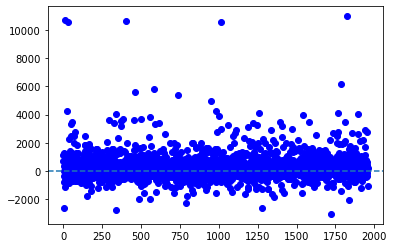

In [108]:
plt.plot(y_pred_E, 'bo')
plt.axhline(y=0, linestyle='--')
plt.show()

I'd like to build some better models, even if they are less interpretable. Things to try:

- k-nearest neighbors
- Random forest
- Neural network

### k-Nearest Neighbors Regression

In [109]:
from sklearn.neighbors import KNeighborsRegressor

In [110]:
pipe, X_train, X_test, y_train, y_test = fit_model(X, y, KNeighborsRegressor(weights='distance'), 0)

In [111]:
pipe.score(X_test, y_test)

0.945492970822294

Much, much better!

What if I use the information I gained from the Elastic Net regression? That is, I will use the data with irrelevant features removed.

In [112]:
pipe, X_train, X_test, y_train, y_test = fit_model(X_E, y, KNeighborsRegressor(weights='distance'), 0)

In [113]:
pipe.score(X_test, y_test)

0.9454464481117824

Not much of an improvement.

In [216]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(weights='distance'))
cutoff = 0.001
X_cutoff = X.iloc[:, np.where((X.sum()/len(X) > cutoff) == True)[0]]
X_train, X_test, y_train, y_test = train_test_split(
    X_cutoff, y, test_size=0.3, random_state=4)
cross_val_score(pipe, X_train, y=y_train)

array([0.24357915, 0.97101526, 0.74296027, 0.98153118, 0.97929122])

In [218]:
cutoffs = [1000, 1, .99, .9, .7, .5, .3, .2, .1, .05, .01, 0.005, 0.001, 0]
test_cutoffs(X, y, KNeighborsRegressor(weights='distance'), cutoffs);

Cutoff =  1e+03, train_score =  0.979, test_score =  0.946, n_features = 4
Cutoff =  1, train_score =  1, test_score =  0.913, n_features = 37
Cutoff =  0.99, train_score =  1, test_score =  0.913, n_features = 39
Cutoff =  0.9, train_score =  1, test_score =  0.902, n_features = 46
Cutoff =  0.7, train_score =  1, test_score =  0.97, n_features = 61
Cutoff =  0.5, train_score =  1, test_score =  0.92, n_features = 69
Cutoff =  0.3, train_score =  1, test_score =  0.862, n_features = 75
Cutoff =  0.2, train_score =  1, test_score =  0.861, n_features = 78
Cutoff =  0.1, train_score =  1, test_score =  0.894, n_features = 85
Cutoff =  0.05, train_score =  1, test_score =  0.943, n_features = 98
Cutoff =  0.01, train_score =  1, test_score =  0.93, n_features = 164
Cutoff =  0.005, train_score =  1, test_score =  0.826, n_features = 202
Cutoff =  0.001, train_score =  1, test_score =  0.833, n_features = 307
Cutoff =  0, train_score =  1, test_score =  0.833, n_features = 739


In [114]:
y_pred_knn = pipe.predict(X_test)

In [116]:
u = ((y_test - y_pred_knn)**2).sum()
v = ((y_test - y_test.mean())**2).sum()
1 - u/v

0.9454464481117824

In [123]:
y_pred_knn[100]

95.8132806775484

In [122]:
list(y_test)[100]

73.0

In [119]:
np.mean(np.abs((y_pred_knn - y_test)))

95.5514158090241

In [125]:
np.mean(np.abs((y_pred_knn - y_test)/y_test))

0.6417666462579966

Intuitively speaking, this is still quite far from a good predictor. On average, it's off from the true values by about $100, or 64%.

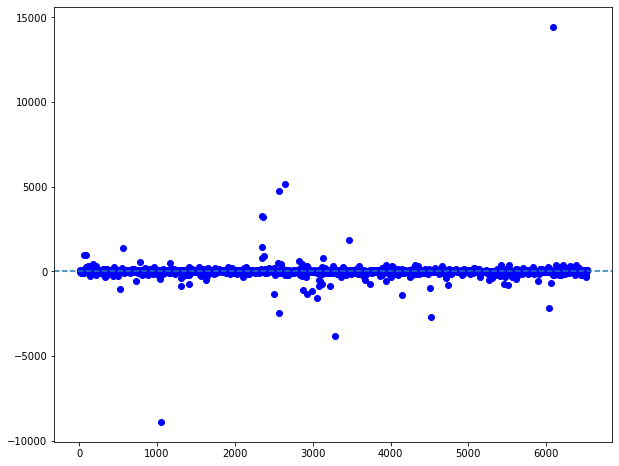

In [126]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_knn - y_test, 'bo')
plt.axhline(y=0, linestyle='--')
#plt.ylim(-200, 200)
plt.show()

In [229]:
listings.loc[1049].head(20)

id                                                                15287352
listing_url                          https://www.airbnb.com/rooms/15287352
scrape_id                                                   20211018161857
last_scraped                                                    2021-10-18
name                                     Wrigleyville Mansion - Sleeps 16+
description              Wrigleyville Mansion is the perfect place to h...
neighborhood_overview    - Wrigley Field<br />- Southport Corridor<br /...
picture_url              https://a0.muscache.com/pictures/dc2c60b9-14f0...
host_id                                                           45401863
host_url                        https://www.airbnb.com/users/show/45401863
host_name                                                              Joe
host_since                                                      2015-09-29
host_location                             Chicago, Illinois, United States
host_about               

In [230]:
y_train.sort_values(ascending=False)[:20]

2341    48864.0
2648    48864.0
2647    48864.0
2361    47484.0
2360    47484.0
2362    47484.0
2346    40356.0
2345    40356.0
2650    39132.0
2350    39132.0
2354    39132.0
2353    39132.0
2358    39132.0
2357    39132.0
2351    39132.0
1049     9999.0
3289     9999.0
3288     9999.0
6196     5000.0
2866     3690.0
Name: price, dtype: float64

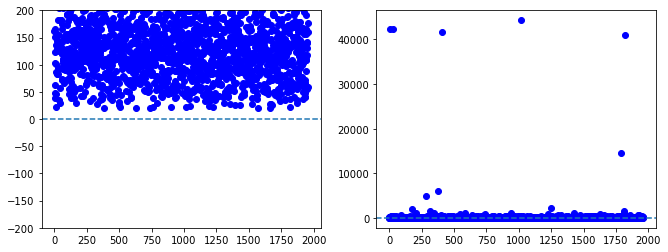

In [136]:
fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].plot(y_pred_knn, 'bo')
ax[0].axhline(y=0, linestyle='--')
ax[0].set_ylim(-200, 200)
ax[1].plot(y_pred_knn, 'bo')
ax[1].axhline(y=0, linestyle='--')
plt.show()

This is at least good - none of the price predictions on the test set are negative.

### Random Forest Regressor

In [137]:
from sklearn.ensemble import RandomForestRegressor

In [157]:
pipe, X_train, X_test, y_train, y_test = fit_model(X, y, RandomForestRegressor(random_state=1), 0)

In [158]:
pipe.score(X_test, y_test)

0.9141108633452861

In [180]:
pipe, X_train, X_test, y_train, y_test = fit_model(X_E, y, RandomForestRegressor(n_estimators=1000,random_state=1), 0)

In [181]:
pipe.score(X_test, y_test)

0.9206594768060465

This is a bit worse than the k-nearest neighbors model! I tried several values of `random_state` and never got anything better than the k-nearest neighbors model.

In [162]:
y_pred_RF = pipe.predict(X_test)

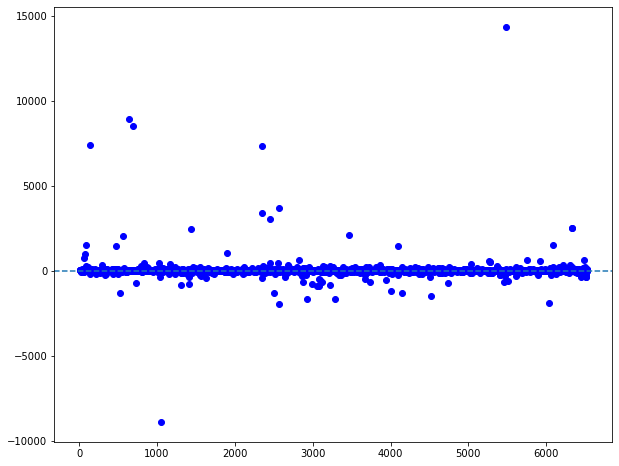

In [163]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_RF - y_test, 'bo')
plt.axhline(y=0, linestyle='--')
#plt.ylim(-200, 200)
plt.show()

### Neural Network (MLP)

Finally, I'll try using a simple neural network model: just a multi-layer perceptron (MLP) without bells and whistles.

In [182]:
from sklearn.neural_network import MLPRegressor

In [185]:
pipe, X_train, X_test, y_train, y_test = fit_model(
    X_E, y, MLPRegressor(random_state=1, max_iter=500), 0)

/Users/tjdauer/miniforge3/envs/myenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [187]:
pipe.score(X_test, y_test)

0.5479664967336064